In [3]:
import pandas as pd
from PyEMD import EMD, Visualisation
import numpy as np
import matplotlib.pyplot as plt
import statistics
from scipy import fftpack
import pywt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier,NeighborhoodComponentsAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn import metrics

In [6]:
# 6 iterations
MicSigV1=pd.read_json ('/Users/lujuanwen/Downloads/MicSigV1/MicSigV1.json') #(1187,11)
MicSigV1['Data_CIIT_6'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['Data_CIIT_6'] = MicSigV1['Data_CIIT_6'].astype('object')
emd = EMD()
#vis = Visualisation()
#plt.plot(t,MicSigV1['Data'][1])
#vis.plot_imfs(imfs=imfs, residue=res, t=t, include_residue=True)
for ind in range(MicSigV1.shape[0]): 
    #1.Decompose noisy input signal into its N subsequent IMFs using EMD.
    data_i=MicSigV1['Data'][ind] 
    emd.emd(np.array(data_i))
    imfs, res = emd.get_imfs_and_residue()
    t = np.arange(0,len(data_i), 1)    
    #2.Denoise, the first IMF, using any thresholding technique.
    N_1=imfs[0].shape[0]
    cov_1=(statistics.median(abs(imfs[0])))/0.675
    T_1 = cov_1*((2*np.log(N_1))**0.5)
    signs_1 = [np.sign(imfs[0][j]) for j in range(imfs[0].shape[0])]
    sign_change_1 = [0]
    imfs_1 = np.zeros(imfs[0].shape[0])
    for sign_1 in range(len(signs_1)-1):
        if signs_1[sign_1] != signs_1[sign_1+1]:
            sign_change_1.append(sign_1+1)  
    for j in range(len(sign_change_1)-1):
        start_point_1=sign_change_1[j]
        end_point_1=sign_change_1[j+1]
        imf_range_1=imfs[0][start_point_1:end_point_1]
        extrema_1 = max(abs(imf_range_1))
        if extrema_1 > T_1:
            pos_range_1= np.arange(start_point_1,end_point_1)
            for k in range(len(pos_range_1)):
                pos = pos_range_1[k]
                val = imf_range_1[k]*((extrema_1-T_1)/extrema_1)
                imfs_1[pos] = val
    #3.Compute the actual noise signal that existed
    noise_signal = imfs[0]- imfs_1
    #4.Perform a partial reconstruction using the last L − 1 IMFs plus the information signal contained in 1st IMF
    imfs[0] = imfs_1
    MicSigV1_CIIT = np.zeros(imfs[0].shape[0])
    for col_i in range(MicSigV1_CIIT.shape[0]):
        for row_i in range(imfs.shape[0]):
            MicSigV1_CIIT[col_i] += imfs[row_i][col_i]
    seed=0
    #5.Randomlyalterthesamplepositionsofthenoise-onlypartofthefirstIMF
    noise_signal = noise_signal[np.random.permutation(noise_signal.shape[0])]
    MicSigV1_CIIT= MicSigV1_CIIT+noise_signal
    #6.Repeat
    M_CIIT_max = 5
    M_CIIT = 1
    M_CIIT_obs =np.zeros((M_CIIT_max+1,imfs.shape[1]))
    M_CIIT_obs[0] = MicSigV1_CIIT
    
    while M_CIIT <= M_CIIT_max:
        data_i= MicSigV1_CIIT
        emd.emd(np.array(data_i))
        imfs, res = emd.get_imfs_and_residue()
        row=imfs.shape[0]
        col=imfs.shape[1]
        imfs_filter = np.zeros((row,col))
        for i in range(imfs.shape[0]):
            N_i=imfs[i].shape[0]
            cov_i=(statistics.median(abs(imfs[i])))/0.675
            T_i = cov_i*((2*np.log(N_i))**0.5)
            signs = [np.sign(imfs[i][j]) for j in range(imfs[i].shape[0])]
            sign_change = [0]   
            for sign in range(len(signs)-1):
                if signs[sign] != signs[sign+1]:
                    sign_change.append(sign+1)
            for j in range(len(sign_change)-1):
                start_point=sign_change[j]
                end_point=sign_change[j+1]
                imf_range=imfs[i][start_point:end_point]
                extrema = max(abs(imf_range))
                if extrema > T_i:
                    pos_range= np.arange(start_point,end_point)
                    for k in range(len(pos_range)):
                        pos = pos_range[k]
                        val=imf_range[k]*((extrema-T_i)/extrema)
                        imfs_filter[i][pos] = val
        
        noise_signal = imfs[0]- imfs_filter[0]
        MicSigV1_CIIT = np.zeros(imfs[0].shape[0])
        for col_i in range(MicSigV1_CIIT.shape[0]):
            for row_i in range(imfs_filter.shape[0]):
                MicSigV1_CIIT[col_i] += imfs_filter[row_i][col_i]   
        seed=0
        noise_signal = noise_signal[np.random.permutation(noise_signal.shape[0])]
        MicSigV1_CIIT= MicSigV1_CIIT+noise_signal
        M_CIIT_obs[M_CIIT] = MicSigV1_CIIT
        M_CIIT =M_CIIT+1
        
    MicSigV1_CIIT_avg=np.average(M_CIIT_obs,axis=0)
    MicSigV1.at[ind, 'Data_CIIT_6'] = list(MicSigV1_CIIT_avg)        

In [8]:
# 4 iterations
MicSigV1['Data_CIIT_4'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['Data_CIIT_4'] = MicSigV1['Data_CIIT_4'].astype('object')

for ind in range(MicSigV1.shape[0]): #
    #1.Decompose noisy input signal into its N subsequent IMFs using EMD.
    data_i=MicSigV1['Data'][ind] 
    emd.emd(np.array(data_i))
    imfs, res = emd.get_imfs_and_residue()
    t = np.arange(0,len(data_i), 1)    
    #2.Denoise, the first IMF, using any thresholding technique.
    N_1=imfs[0].shape[0]
    cov_1=(statistics.median(abs(imfs[0])))/0.675
    T_1 = cov_1*((2*np.log(N_1))**0.5)
    signs_1 = [np.sign(imfs[0][j]) for j in range(imfs[0].shape[0])]
    sign_change_1 = [0]
    imfs_1 = np.zeros(imfs[0].shape[0])
    for sign_1 in range(len(signs_1)-1):
        if signs_1[sign_1] != signs_1[sign_1+1]:
            sign_change_1.append(sign_1+1)  
    for j in range(len(sign_change_1)-1):
        start_point_1=sign_change_1[j]
        end_point_1=sign_change_1[j+1]
        imf_range_1=imfs[0][start_point_1:end_point_1]
        extrema_1 = max(abs(imf_range_1))
        if extrema_1 > T_1:
            pos_range_1= np.arange(start_point_1,end_point_1)
            for k in range(len(pos_range_1)):
                pos = pos_range_1[k]
                val = imf_range_1[k]*((extrema_1-T_1)/extrema_1)
                imfs_1[pos] = val
    #3.Compute the actual noise signal that existed
    noise_signal = imfs[0]- imfs_1
    #4.Perform a partial reconstruction using the last L − 1 IMFs plus the information signal contained in 1st IMF
    imfs[0] = imfs_1
    MicSigV1_CIIT = np.zeros(imfs[0].shape[0])
    for col_i in range(MicSigV1_CIIT.shape[0]):
        for row_i in range(imfs.shape[0]):
            MicSigV1_CIIT[col_i] += imfs[row_i][col_i]
    seed=0
    #5.Randomly alter the sample positions o fthe noise-only part of the first IMF
    noise_signal = noise_signal[np.random.permutation(noise_signal.shape[0])]
    MicSigV1_CIIT= MicSigV1_CIIT+noise_signal
    #6.Repeat
    M_CIIT_max = 3
    M_CIIT = 1
    M_CIIT_obs =np.zeros((M_CIIT_max+1,imfs.shape[1]))
    M_CIIT_obs[0] = MicSigV1_CIIT
    
    while M_CIIT <= M_CIIT_max:
        data_i= MicSigV1_CIIT
        emd.emd(np.array(data_i))
        imfs, res = emd.get_imfs_and_residue()
        row=imfs.shape[0]
        col=imfs.shape[1]
        imfs_filter = np.zeros((row,col))
        for i in range(imfs.shape[0]):
            N_i=imfs[i].shape[0]
            cov_i=(statistics.median(abs(imfs[i])))/0.675
            T_i = cov_i*((2*np.log(N_i))**0.5)
            signs = [np.sign(imfs[i][j]) for j in range(imfs[i].shape[0])]
            sign_change = [0]   
            for sign in range(len(signs)-1):
                if signs[sign] != signs[sign+1]:
                    sign_change.append(sign+1)
            for j in range(len(sign_change)-1):
                start_point=sign_change[j]
                end_point=sign_change[j+1]
                imf_range=imfs[i][start_point:end_point]
                extrema = max(abs(imf_range))
                if extrema > T_i:
                    pos_range= np.arange(start_point,end_point)
                    for k in range(len(pos_range)):
                        pos = pos_range[k]
                        val=imf_range[k]*((extrema-T_i)/extrema)
                        imfs_filter[i][pos] = val
        
        noise_signal = imfs[0]- imfs_filter[0]
        MicSigV1_CIIT = np.zeros(imfs[0].shape[0])
        for col_i in range(MicSigV1_CIIT.shape[0]):
            for row_i in range(imfs_filter.shape[0]):
                MicSigV1_CIIT[col_i] += imfs_filter[row_i][col_i]   
        seed=0
        noise_signal = noise_signal[np.random.permutation(noise_signal.shape[0])]
        MicSigV1_CIIT= MicSigV1_CIIT+noise_signal
        M_CIIT_obs[M_CIIT] = MicSigV1_CIIT
        M_CIIT =M_CIIT+1
        
    MicSigV1_CIIT_avg=np.average(M_CIIT_obs,axis=0)
    MicSigV1.at[ind, 'Data_CIIT_4'] = list(MicSigV1_CIIT_avg)        

In [10]:
# 2 iterations
MicSigV1['Data_CIIT_2'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['Data_CIIT_2'] = MicSigV1['Data_CIIT_2'].astype('object')

for ind in range(MicSigV1.shape[0]): #
    #1.Decompose noisy input signal into its N subsequent IMFs using EMD.
    data_i=MicSigV1['Data'][ind] 
    emd.emd(np.array(data_i))
    imfs, res = emd.get_imfs_and_residue()
    t = np.arange(0,len(data_i), 1)    
    #2.Denoise, the first IMF, using any thresholding technique.
    N_1=imfs[0].shape[0]
    cov_1=(statistics.median(abs(imfs[0])))/0.675
    T_1 = cov_1*((2*np.log(N_1))**0.5)
    signs_1 = [np.sign(imfs[0][j]) for j in range(imfs[0].shape[0])]
    sign_change_1 = [0]
    imfs_1 = np.zeros(imfs[0].shape[0])
    for sign_1 in range(len(signs_1)-1):
        if signs_1[sign_1] != signs_1[sign_1+1]:
            sign_change_1.append(sign_1+1)  
    for j in range(len(sign_change_1)-1):
        start_point_1=sign_change_1[j]
        end_point_1=sign_change_1[j+1]
        imf_range_1=imfs[0][start_point_1:end_point_1]
        extrema_1 = max(abs(imf_range_1))
        if extrema_1 > T_1:
            pos_range_1= np.arange(start_point_1,end_point_1)
            for k in range(len(pos_range_1)):
                pos = pos_range_1[k]
                val = imf_range_1[k]*((extrema_1-T_1)/extrema_1)
                imfs_1[pos] = val
    #3.Compute the actual noise signal that existed
    noise_signal = imfs[0]- imfs_1
    #4.Perform a partial reconstruction using the last L − 1 IMFs plus the information signal contained in 1st IMF
    imfs[0] = imfs_1
    MicSigV1_CIIT = np.zeros(imfs[0].shape[0])
    for col_i in range(MicSigV1_CIIT.shape[0]):
        for row_i in range(imfs.shape[0]):
            MicSigV1_CIIT[col_i] += imfs[row_i][col_i]
    seed=0
    #5.Randomly alter the sample positions o fthe noise-only part of the first IMF
    noise_signal = noise_signal[np.random.permutation(noise_signal.shape[0])]
    MicSigV1_CIIT= MicSigV1_CIIT+noise_signal
    #6.Repeat
    M_CIIT_max = 1
    M_CIIT = 1
    M_CIIT_obs =np.zeros((M_CIIT_max+1,imfs.shape[1]))
    M_CIIT_obs[0] = MicSigV1_CIIT
    
    while M_CIIT <= M_CIIT_max:
        data_i= MicSigV1_CIIT
        emd.emd(np.array(data_i))
        imfs, res = emd.get_imfs_and_residue()
        row=imfs.shape[0]
        col=imfs.shape[1]
        imfs_filter = np.zeros((row,col))
        for i in range(imfs.shape[0]):
            N_i=imfs[i].shape[0]
            cov_i=(statistics.median(abs(imfs[i])))/0.675
            T_i = cov_i*((2*np.log(N_i))**0.5)
            signs = [np.sign(imfs[i][j]) for j in range(imfs[i].shape[0])]
            sign_change = [0]   
            for sign in range(len(signs)-1):
                if signs[sign] != signs[sign+1]:
                    sign_change.append(sign+1)
            for j in range(len(sign_change)-1):
                start_point=sign_change[j]
                end_point=sign_change[j+1]
                imf_range=imfs[i][start_point:end_point]
                extrema = max(abs(imf_range))
                if extrema > T_i:
                    pos_range= np.arange(start_point,end_point)
                    for k in range(len(pos_range)):
                        pos = pos_range[k]
                        val=imf_range[k]*((extrema-T_i)/extrema)
                        imfs_filter[i][pos] = val
        
        noise_signal = imfs[0]- imfs_filter[0]
        MicSigV1_CIIT = np.zeros(imfs[0].shape[0])
        for col_i in range(MicSigV1_CIIT.shape[0]):
            for row_i in range(imfs_filter.shape[0]):
                MicSigV1_CIIT[col_i] += imfs_filter[row_i][col_i]   
        seed=0
        noise_signal = noise_signal[np.random.permutation(noise_signal.shape[0])]
        MicSigV1_CIIT= MicSigV1_CIIT+noise_signal
        M_CIIT_obs[M_CIIT] = MicSigV1_CIIT
        M_CIIT =M_CIIT+1
        
    MicSigV1_CIIT_avg=np.average(M_CIIT_obs,axis=0)
    MicSigV1.at[ind, 'Data_CIIT_2'] = list(MicSigV1_CIIT_avg)  

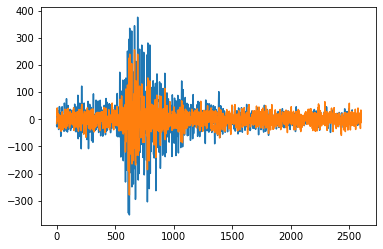

In [11]:
plt.plot(np.arange(0,len(MicSigV1['Data'][1185]),1),MicSigV1['Data'][1185])
plt.plot(np.arange(0,len(MicSigV1['Data'][1185]),1),MicSigV1['Data_CIIT_2'][1185])

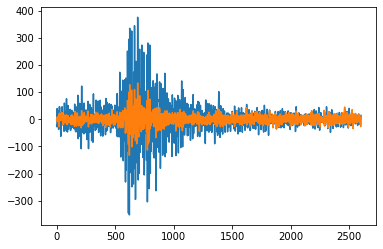

In [9]:
plt.plot(np.arange(0,len(MicSigV1['Data'][1185]),1),MicSigV1['Data'][1185])
plt.plot(np.arange(0,len(MicSigV1['Data'][1185]),1),MicSigV1['Data_CIIT_4'][1185])

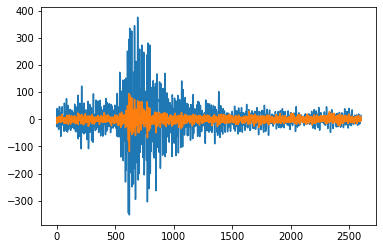

In [7]:
plt.plot(np.arange(0,len(MicSigV1['Data'][1185]),1),MicSigV1['Data'][1185])
plt.plot(np.arange(0,len(MicSigV1['Data'][1185]),1),MicSigV1['Data_CIIT_6'][1185])

In [12]:
#normalize the data in the range (-1,1)

def signaltonoise_dB(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return 20*np.log10(abs(np.where(sd == 0, 0, m/sd)))

scaler = MinMaxScaler(feature_range=(-1, 1))

MicSigV1['NORM_CIIT_6'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['NORM_CIIT_4'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['NORM_CIIT_2'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['NORM_CIIT'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['NORM_CIIT_6'] = MicSigV1['NORM_CIIT_6'].astype('object')
MicSigV1['NORM_CIIT_4'] = MicSigV1['NORM_CIIT_4'].astype('object')
MicSigV1['NORM_CIIT_2'] = MicSigV1['NORM_CIIT_2'].astype('object')
MicSigV1['NORM_CIIT'] = MicSigV1['NORM_CIIT'].astype('object')

stn_array_original = []
for ind in range(MicSigV1['Data'].shape[0]):
    scaled = scaler.fit_transform([[x] for x in MicSigV1['Data'][ind]])
    signal = MicSigV1['Data'][ind]
    MicSigV1.at[ind, 'NORM_CIIT'] = list(scaled)  
    stn_array_original.append(signaltonoise_dB(signal))

stn_array_2iter = []
for ind in range(MicSigV1['Data_CIIT_2'].shape[0]):
    scaled = scaler.fit_transform([[x] for x in MicSigV1['Data_CIIT_2'][ind]])
    signal = MicSigV1['Data_CIIT_2'][ind]
    MicSigV1.at[ind, 'NORM_CIIT_2'] = list(scaled)  
    stn_array_original.append(signaltonoise_dB(signal))

stn_array_4iter = []
for ind in range(MicSigV1['Data_CIIT_4'].shape[0]):
    scaled = scaler.fit_transform([[x] for x in MicSigV1['Data_CIIT_4'][ind]])
    signal = MicSigV1['Data_CIIT_4'][ind]
    MicSigV1.at[ind, 'NORM_CIIT_4'] = list(scaled)  
    stn_array_original.append(signaltonoise_dB(signal))

stn_array_6iter = []
for ind in range(MicSigV1['Data_CIIT_6'].shape[0]):
    scaled = scaler.fit_transform([[x] for x in MicSigV1['Data_CIIT_6'][ind]])
    signal = MicSigV1['Data_CIIT_6'][ind]
    MicSigV1.at[ind, 'NORM_CIIT_6'] = list(scaled)  
    stn_array_original.append(signaltonoise_dB(signal))


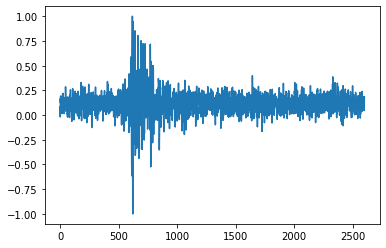

In [15]:
plt.plot(np.arange(0,len(MicSigV1['Data'][1185]),1),MicSigV1['NORM_CIIT_6'][1185])

In [16]:
#First Dimension: the Maximum Threshold Frequency (20-30 Hz) #f26 
#code from https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html

MicSigV1['Freq_Raw'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['Freq_2'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['Freq_4'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['Freq_6'] = np.zeros((MicSigV1.shape[0]))

for ind in range((MicSigV1.shape[0])):
    duration = MicSigV1['Duration'][ind]
    f_s=len(MicSigV1['Data'][ind])/duration
    freq=len(MicSigV1['Data'][ind])
    X_raw = fftpack.fft(MicSigV1['NORM_CIIT'][ind])
    X_2 = fftpack.fft(MicSigV1['NORM_CIIT_2'][ind])
    X_4 = fftpack.fft(MicSigV1['NORM_CIIT_4'][ind])
    X_6 = fftpack.fft(MicSigV1['NORM_CIIT_6'][ind])
    freqs = fftpack.fftfreq(freq) * f_s
    index_list =[ind for ind,val in enumerate(freqs) if val <=30 and val >=20 ]
    MicSigV1.loc[ind,"Freq_Raw"]=freqs[np.where(X_raw==max(X_raw[index_list]))[0][0]]
    MicSigV1.loc[ind,'Freq_2']= freqs[np.where(X_2==max(X_2[index_list]))[0][0]]  
    MicSigV1.loc[ind,'Freq_4']= freqs[np.where(X_4==max(X_4[index_list]))[0][0]] 
    MicSigV1.loc[ind,'Freq_6']= freqs[np.where(X_6==max(X_6[index_list]))[0][0]] 

In [17]:
#2nd Dimension: D1 Max. peak in freq.-domain  
waveletname= 'sym6'
MicSigV1['D1_Max_Raw'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['D1_Max_2'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['D1_Max_4'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['D1_Max_6'] = np.zeros((MicSigV1.shape[0]))

for ind in range((MicSigV1.shape[0])):
    duration = MicSigV1['Duration'][ind]
    #normalized raw data
    data_raw = MicSigV1['Data'][ind]
    (data_raw, coeff_d) = pywt.dwt(data_raw, waveletname)
    f_s_raw=len(data_raw)/duration
    freq_raw=len(data_raw)
    X_raw = fftpack.fft(data_raw)
    freqs_raw = fftpack.fftfreq(freq_raw) * f_s_raw
    MicSigV1.loc[ind,'D1_Max_Raw']=freqs_raw[np.where(X_raw==np.max(X_raw))[0][0]]
    #normalized data after CIIT 2 iterations
    data2 = MicSigV1['Data_CIIT_2'][ind]
    (data2, coeff_d) = pywt.dwt(data2, waveletname)
    f_s2=len(data2)/duration
    freq2=len(data2)
    X2 = fftpack.fft(data2)
    freqs2 = fftpack.fftfreq(freq2) * f_s2
    MicSigV1.loc[ind,'D1_Max_2']=freqs2[np.where(X2==np.max(X2))[0][0]]
    #normalized data after CIIT 4 iterations
    data4 = MicSigV1['Data_CIIT_4'][ind]
    (data4, coeff_d) = pywt.dwt(data4, waveletname)
    f_s4=len(data4)/duration
    freq4=len(data4)
    X4 = fftpack.fft(data4)
    freqs4 = fftpack.fftfreq(freq4) * f_s4
    MicSigV1.loc[ind,'D1_Max_4']=freqs4[np.where(X4==np.max(X4))[0][0]]
    #normalized data after CIIT 6 iterations
    data6 = MicSigV1['Data_CIIT_6'][ind]
    (data6, coeff_d) = pywt.dwt(data6, waveletname)
    f_s6=len(data6)/duration
    freq6=len(data6)
    X6 = fftpack.fft(data6)
    freqs6 = fftpack.fftfreq(freq6) * f_s6
    MicSigV1.loc[ind,'D1_Max_6']=freqs6[np.where(X6==np.max(X6))[0][0]]


In [18]:
# 3rd Dimension: the entropy in the time domain
MicSigV1['E_Raw'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['E_2'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['E_4'] = np.zeros((MicSigV1.shape[0]))
MicSigV1['E_6'] = np.zeros((MicSigV1.shape[0]))
for ind in range((MicSigV1.shape[0])):
    data_raw = MicSigV1['NORM_CIIT'][ind]
    data2 = MicSigV1['NORM_CIIT_2'][ind]
    data4 = MicSigV1['NORM_CIIT_4'][ind]
    data6 = MicSigV1['NORM_CIIT_6'][ind]
    MicSigV1.loc[ind,'E_Raw'] = - np.sum([ (x**2)*np.log(x**2) for x in data_raw ])
    MicSigV1.loc[ind,'E_2'] = - np.sum([ (x**2)*np.log(x**2) for x in data2 ])
    MicSigV1.loc[ind,'E_4'] = - np.sum([ (x**2)*np.log(x**2) for x in data4 ])
    MicSigV1.loc[ind,'E_6'] = - np.sum([ (x**2)*np.log(x**2) for x in data6 ])

In [49]:
#Cleanning data
ind = np.where( MicSigV1['Type'] == '''['REGIONAL']''')
ind2 = np.where( MicSigV1['Type'] == '''['LP']''')
ind3 = np.where( MicSigV1['Type'] == '''VT ''')
MicSigV1['Type'].loc[ind[0]]  = "REGIONAL"
MicSigV1['Type'].loc[ind2[0]] = "LP"
MicSigV1['Type'].loc[ind3[0]] = "VT"

label_encoder = LabelEncoder()
MicSigV1['Type']=MicSigV1['Type'].astype('str')
MicSigV1['Type_CatNbr'] = label_encoder.fit_transform((MicSigV1['Type'].values))
y=MicSigV1['Type_CatNbr']
Type_Mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
Key_List=[key for key in Type_Mapping.keys()]

/Users/lujuanwen/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


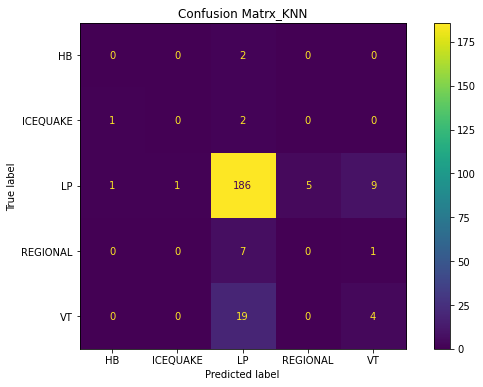

/Users/lujuanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[  0,   0,   2,   0,   0],
       [  0,   0,   3,   0,   0],
       [  0,   0, 202,   0,   0],
       [  0,   0,   7,   1,   0],
       [  0,   0,  23,   0,   0]])

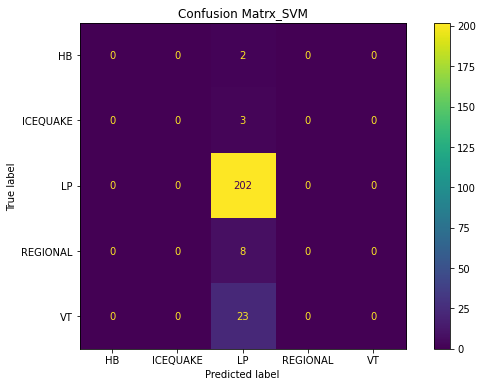

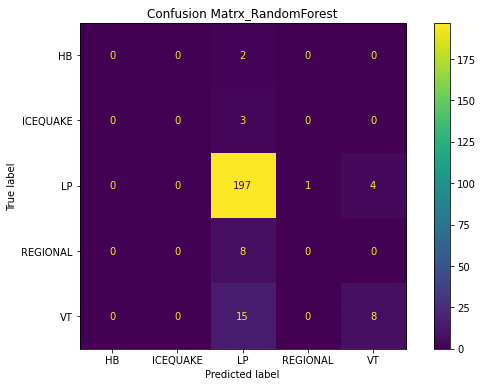

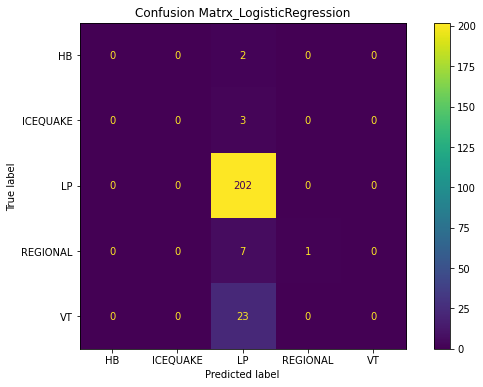

In [75]:
# Classification Model - Normalized Raw Data
# Split the data
X=MicSigV1[['E_Raw','D1_Max_Raw','Freq_Raw']]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

#Knn Model
no_neighbors = np.arange(2,50,5)
accuracy_knn = np.zeros((no_neighbors.shape[0]))
k=0
for knn in no_neighbors:
    knn_model= KNeighborsClassifier(n_neighbors=knn).fit(X_train, y_train)
    yts_knnpred= knn_model.predict(X_test) #confusion_matrix(y_train, y_pred)
    accuracy_knn[k]=accuracy_score(y_test, yts_knnpred)
    k += 1
opt_knn= np.where(accuracy_knn == max(accuracy_knn))[0][0]
optknn_model= KNeighborsClassifier(n_neighbors=opt_knn).fit(X_train, y_train)
optyts_knnpred= knn_model.predict(X_test) 
confusion_matrix(y_test,optyts_knnpred )
#accuracy_score(y_test,optyts_knnpred ) #0.8487394957983193
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_KNN')
disp =metrics.plot_confusion_matrix(optknn_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp.confusion_matrix
plt.show()

#SVM for multiclasses
svm_model=SVC(gamma='auto',decision_function_shape='ovo').fit(X_train, y_train)
yts_svm=svm_model.predict(X_test) 
confusion_matrix(y_test,yts_svm ) 
#accuracy_score(y_test,yts_svm ) #0.8487394957983193
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_SVM')
disp2 =metrics.plot_confusion_matrix(svm_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp2.confusion_matrix

#random forest
rf_model=RandomForestClassifier(n_estimators = 1000, random_state = 42).fit(X_train, y_train)
yts_rf=rf_model.predict(X_test)
confusion_matrix(y_test,yts_rf )
accuracy_score(y_test,yts_rf ) #0.8613445378151261
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_RandomForest')
disp3 =metrics.plot_confusion_matrix(rf_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp3.confusion_matrix

#Kmeans 
km_model = KMeans(n_clusters=5, random_state=42).fit_predict(X)
confusion_matrix(y,km_model )
accuracy_score(y,km_model )  #0.2384161752316765

#sc = preprocessing.StandardScaler()
#scaler = sc.fit_transform(X_train)
lr = linear_model.LogisticRegression(multi_class='multinomial',max_iter=1000).fit(X_train, y_train)
yts_lr=lr.predict(X_test)
accuracy_score(y_test,yts_lr ) #0.8529411764705882
confusion_matrix(y_test,yts_lr )
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_LogisticRegression')
disp4 =metrics.plot_confusion_matrix(lr, X_test, y_test, display_labels= Key_List, ax = ax)
disp4.confusion_matrix


In [76]:
#acc of Normalized raw data
print("Acc-KNN", round(accuracy_score(y_test,optyts_knnpred)*100,2),"%")
print("Acc-SVM",round(accuracy_score(y_test,yts_svm )*100,2),"%")
print("Acc-RF",round(accuracy_score(y_test,yts_rf )*100,2),"%")
print("Acc-Kmeans",round(accuracy_score(y,km_model )*100,2),"%")
print("Acc-LR",round(accuracy_score(y_test,yts_lr )*100,2),"%")

Acc-KNN 84.87 %
Acc-SVM 84.87 %
Acc-RF 86.13 %
Acc-Kmeans 23.84 %
Acc-LR 85.29 %


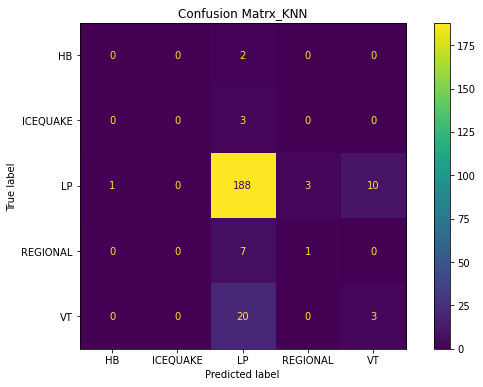

/Users/lujuanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[  0,   0,   2,   0,   0],
       [  0,   0,   3,   0,   0],
       [  0,   0, 202,   0,   0],
       [  0,   0,   7,   1,   0],
       [  0,   0,  23,   0,   0]])

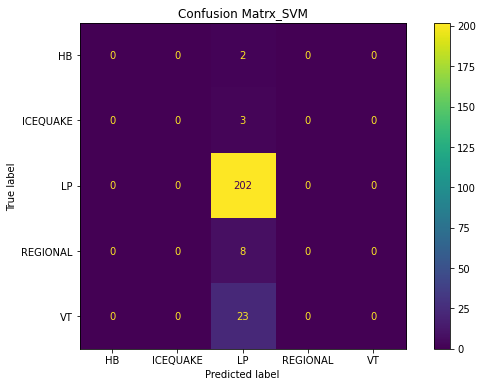

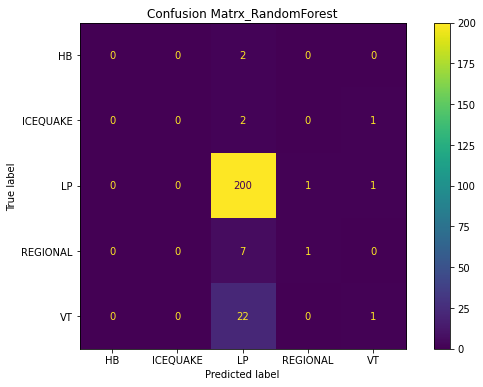

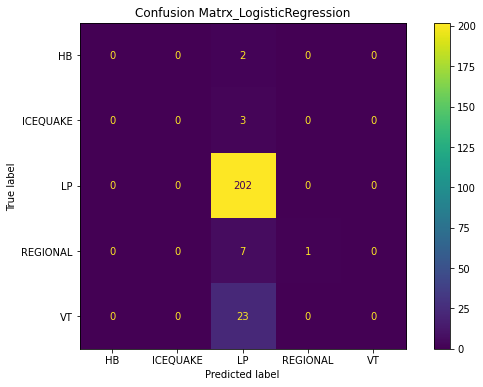

In [73]:
# Classification Model - Normalized CIIT 2
# Split the data
X=MicSigV1[['E_2','D1_Max_2','Freq_2']]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

#Knn Model
no_neighbors = np.arange(2,50,5)
accuracy_knn = np.zeros((no_neighbors.shape[0]))
k=0
for knn in no_neighbors:
    knn_model= KNeighborsClassifier(n_neighbors=knn).fit(X_train, y_train)
    yts_knnpred= knn_model.predict(X_test) #confusion_matrix(y_train, y_pred)
    accuracy_knn[k]=accuracy_score(y_test, yts_knnpred)
    k += 1
opt_knn= np.where(accuracy_knn == max(accuracy_knn))[0][0]
optknn_model= KNeighborsClassifier(n_neighbors=opt_knn).fit(X_train, y_train)
optyts_knnpred= knn_model.predict(X_test) 
confusion_matrix(y_test,optyts_knnpred )
#accuracy_score(y_test,optyts_knnpred ) #0.8487394957983193
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_KNN')
disp =metrics.plot_confusion_matrix(optknn_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp.confusion_matrix
plt.show()

#SVM for multiclasses
svm_model=SVC(gamma='auto',decision_function_shape='ovo').fit(X_train, y_train)
yts_svm=svm_model.predict(X_test) 
confusion_matrix(y_test,yts_svm ) 
#accuracy_score(y_test,yts_svm ) #0.8487394957983193
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_SVM')
disp2 =metrics.plot_confusion_matrix(svm_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp2.confusion_matrix

#random forest
rf_model=RandomForestClassifier(n_estimators = 1000, random_state = 42).fit(X_train, y_train)
yts_rf=rf_model.predict(X_test)
confusion_matrix(y_test,yts_rf )
accuracy_score(y_test,yts_rf ) #0.8613445378151261
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_RandomForest')
disp3 =metrics.plot_confusion_matrix(rf_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp3.confusion_matrix

#Kmeans 
km_model = KMeans(n_clusters=5, random_state=42).fit_predict(X)
confusion_matrix(y,km_model )
accuracy_score(y,km_model )  #0.2384161752316765

#sc = preprocessing.StandardScaler()
#scaler = sc.fit_transform(X_train)
lr = linear_model.LogisticRegression(multi_class='multinomial',max_iter=1000).fit(X_train, y_train)
yts_lr=lr.predict(X_test)
#accuracy_score(y_test,yts_lr ) #0.8529411764705882
confusion_matrix(y_test,yts_lr )
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_LogisticRegression')
disp4 =metrics.plot_confusion_matrix(lr, X_test, y_test, display_labels= Key_List, ax = ax)
disp4.confusion_matrix


In [74]:
#acc of Normalized CIIT 2
print("Acc-KNN", round(accuracy_score(y_test,optyts_knnpred)*100,2),"%")
print("Acc-SVM",round(accuracy_score(y_test,yts_svm )*100,2),"%")
print("Acc-RF",round(accuracy_score(y_test,yts_rf )*100,2),"%")
print("Acc-Kmeans",round(accuracy_score(y,km_model )*100,2),"%")
print("Acc-LR",round(accuracy_score(y_test,yts_lr )*100,2),"%")

Acc-KNN 84.87 %
Acc-SVM 84.87 %
Acc-RF 84.87 %
Acc-Kmeans 6.32 %
Acc-LR 85.29 %


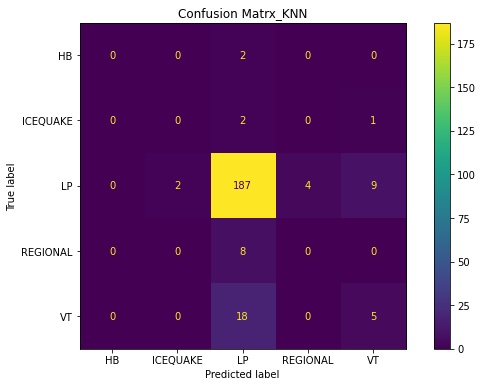

array([[  0,   0,   2,   0,   0],
       [  0,   0,   3,   0,   0],
       [  0,   0, 202,   0,   0],
       [  0,   0,   7,   1,   0],
       [  0,   0,  23,   0,   0]])

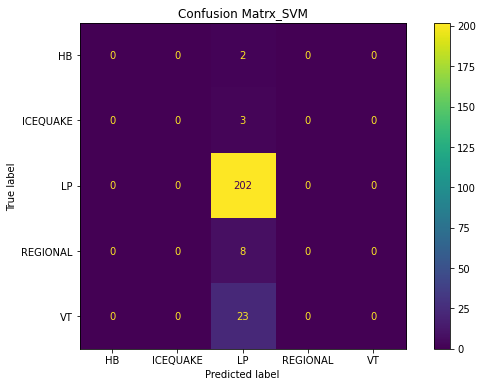

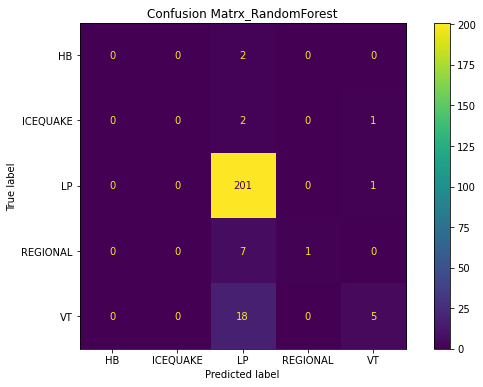

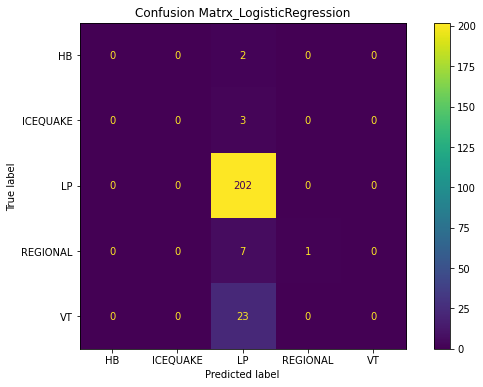

In [53]:
# Classification Model - Normalized CIIT 4
# Split the data
X=MicSigV1[['E_4','D1_Max_4','Freq_4']]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

#Knn Model
no_neighbors = np.arange(2,50,5)
accuracy_knn = np.zeros((no_neighbors.shape[0]))
k=0
for knn in no_neighbors:
    knn_model= KNeighborsClassifier(n_neighbors=knn).fit(X_train, y_train)
    yts_knnpred= knn_model.predict(X_test) #confusion_matrix(y_train, y_pred)
    accuracy_knn[k]=accuracy_score(y_test, yts_knnpred)
    k += 1
opt_knn= np.where(accuracy_knn == max(accuracy_knn))[0][0]
optknn_model= KNeighborsClassifier(n_neighbors=opt_knn).fit(X_train, y_train)
optyts_knnpred= knn_model.predict(X_test) 
confusion_matrix(y_test,optyts_knnpred )
#accuracy_score(y_test,optyts_knnpred ) #0.8487394957983193
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_KNN')
disp =metrics.plot_confusion_matrix(optknn_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp.confusion_matrix
plt.show()

#SVM for multiclasses
svm_model=SVC(gamma='auto',decision_function_shape='ovo').fit(X_train, y_train)
yts_svm=svm_model.predict(X_test) 
confusion_matrix(y_test,yts_svm ) 
#accuracy_score(y_test,yts_svm ) #0.8487394957983193
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_SVM')
disp2 =metrics.plot_confusion_matrix(svm_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp2.confusion_matrix

#random forest
rf_model=RandomForestClassifier(n_estimators = 1000, random_state = 42).fit(X_train, y_train)
yts_rf=rf_model.predict(X_test)
confusion_matrix(y_test,yts_rf )
accuracy_score(y_test,yts_rf ) #0.8613445378151261
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_RandomForest')
disp3 =metrics.plot_confusion_matrix(rf_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp3.confusion_matrix

#Kmeans 
km_model = KMeans(n_clusters=5, random_state=42).fit_predict(X)
confusion_matrix(y,km_model )
accuracy_score(y,km_model )  #0.2384161752316765

#sc = preprocessing.StandardScaler()
#scaler = sc.fit_transform(X_train)
lr = linear_model.LogisticRegression(multi_class='multinomial',max_iter=1000).fit(X_train, y_train)
yts_lr=lr.predict(X_test)
accuracy_score(y_test,yts_lr ) #0.8529411764705882
confusion_matrix(y_test,yts_lr )
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_LogisticRegression')
disp4 =metrics.plot_confusion_matrix(lr, X_test, y_test, display_labels= Key_List, ax = ax)
disp4.confusion_matrix


In [68]:
#acc of Normalized CIIT 4
print("Acc-KNN", round(accuracy_score(y_test,optyts_knnpred)*100,2),"%")
print("Acc-SVM",round(accuracy_score(y_test,yts_svm )*100,2),"%")
print("Acc-RF",round(accuracy_score(y_test,yts_rf )*100,2),"%")
print("Acc-Kmeans",round(accuracy_score(y,km_model )*100,2),"%")
print("Acc-LR",round(accuracy_score(y_test,yts_lr )*100,2),"%")

Acc-KNN 84.87 %
Acc-SVM 84.87 %
Acc-RF 84.87 %
Acc-Kmeans 6.32 %
Acc-LR 85.29 %


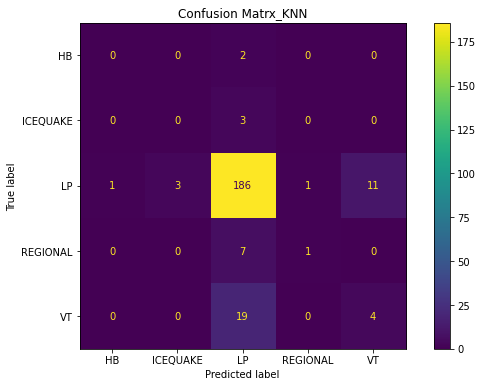

/Users/lujuanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[  0,   0,   2,   0,   0],
       [  0,   0,   3,   0,   0],
       [  0,   0, 202,   0,   0],
       [  0,   0,   7,   1,   0],
       [  0,   0,  23,   0,   0]])

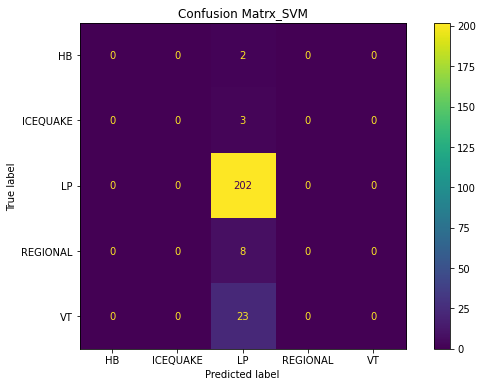

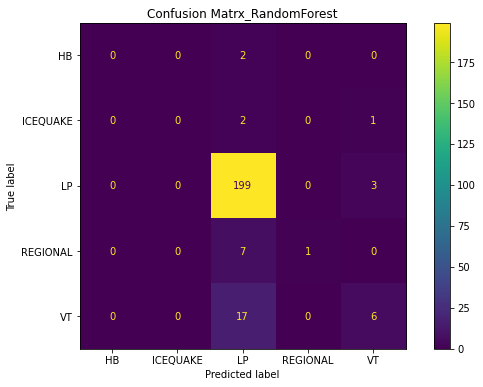

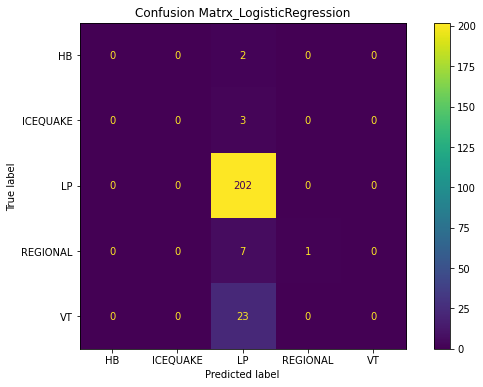

In [69]:
# Classification Model - Normalized CIIT 6
# Split the data
X=MicSigV1[['E_6','D1_Max_6','Freq_6']]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

#Knn Model
no_neighbors = np.arange(2,50,5)
accuracy_knn = np.zeros((no_neighbors.shape[0]))
k=0
for knn in no_neighbors:
    knn_model= KNeighborsClassifier(n_neighbors=knn).fit(X_train, y_train)
    yts_knnpred= knn_model.predict(X_test) #confusion_matrix(y_train, y_pred)
    accuracy_knn[k]=accuracy_score(y_test, yts_knnpred)
    k += 1
opt_knn= np.where(accuracy_knn == max(accuracy_knn))[0][0]
optknn_model= KNeighborsClassifier(n_neighbors=opt_knn).fit(X_train, y_train)
optyts_knnpred= knn_model.predict(X_test) 
confusion_matrix(y_test,optyts_knnpred )
#accuracy_score(y_test,optyts_knnpred ) #0.8487394957983193
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_KNN')
disp =metrics.plot_confusion_matrix(optknn_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp.confusion_matrix
plt.show()

#SVM for multiclasses
svm_model=SVC(gamma='auto',decision_function_shape='ovo').fit(X_train, y_train)
yts_svm=svm_model.predict(X_test) 
confusion_matrix(y_test,yts_svm ) 
#accuracy_score(y_test,yts_svm ) #0.8487394957983193
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_SVM')
disp2 =metrics.plot_confusion_matrix(svm_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp2.confusion_matrix

#random forest
rf_model=RandomForestClassifier(n_estimators = 1000, random_state = 42).fit(X_train, y_train)
yts_rf=rf_model.predict(X_test)
confusion_matrix(y_test,yts_rf )
accuracy_score(y_test,yts_rf ) #0.8613445378151261
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_RandomForest')
disp3 =metrics.plot_confusion_matrix(rf_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp3.confusion_matrix

#Kmeans 
km_model = KMeans(n_clusters=5, random_state=42).fit_predict(X)
confusion_matrix(y,km_model )
accuracy_score(y,km_model )  #0.2384161752316765

#sc = preprocessing.StandardScaler()
#scaler = sc.fit_transform(X_train)
lr = linear_model.LogisticRegression(multi_class='multinomial',max_iter=1000).fit(X_train, y_train)
yts_lr=lr.predict(X_test)
accuracy_score(y_test,yts_lr ) #0.8529411764705882
confusion_matrix(y_test,yts_lr )
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_LogisticRegression')
disp4 =metrics.plot_confusion_matrix(lr, X_test, y_test, display_labels= Key_List, ax = ax)
disp4.confusion_matrix


In [70]:
#acc of Normalized CIIT 6
print("Acc-KNN", round(accuracy_score(y_test,optyts_knnpred)*100,2),"%")
print("Acc-SVM",round(accuracy_score(y_test,yts_svm )*100,2),"%")
print("Acc-RF",round(accuracy_score(y_test,yts_rf )*100,2),"%")
print("Acc-Kmeans",round(accuracy_score(y,km_model )*100,2),"%")
print("Acc-LR",round(accuracy_score(y_test,yts_lr )*100,2),"%")

Acc-KNN 84.87 %
Acc-SVM 84.87 %
Acc-RF 86.55 %
Acc-Kmeans 29.74 %
Acc-LR 85.29 %
